# Imports

In [ ]:
train_url = 'https://github.com/sidt-ai/MH-hackathons/blob/main/dare_in_reality_2021/data/raw/train.csv?raw=true'
test_url = 'https://raw.githubusercontent.com/sidt-ai/MH-hackathons/main/dare_in_reality_2021/data/raw/test.csv'
train_weather_url = 'https://raw.githubusercontent.com/sidt-ai/MH-hackathons/main/dare_in_reality_2021/data/raw/train_weather.csv'
test_weather_url = 'https://raw.githubusercontent.com/sidt-ai/MH-hackathons/main/dare_in_reality_2021/data/raw/test_weather.csv'

In [ ]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train = pd.read_csv(train_url, skipinitialspace=True)
test = pd.read_csv(test_url, skipinitialspace=True)
train_weather = pd.read_csv(train_weather_url, skipinitialspace=True)
test_weather = pd.read_csv(test_weather_url, skipinitialspace=True)

# Data Exploration and Cleaning: train.csv, test.csv

### Data Preview

In [ ]:
train.head(3)

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,KPH,ELAPSED,HOUR,S1_LARGE,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT
0,10,1,1,92,0,NaN,05:43.3,0,35.427,0,43.313,0,28.8,07:02.0,22:02.0,05:43.3,00:35.4,00:43.3,SB,05:14.7,NaN,JR,NaN,Location 2,Free Practice 2
1,10,1,2,87,2,NaN,25.674,2,33.399,2,41.922,2,120.5,08:43.0,23:43.0,00:25.7,00:33.4,00:41.9,SB,NaN,NaN,JR,NaN,Location 2,Free Practice 2
2,10,1,3,73,0,B,28.129,0,34.091,0,57.248,0,101.9,10:42.5,25:42.5,00:28.1,00:34.1,00:57.2,SB,NaN,NaN,JR,NaN,Location 2,Free Practice 2


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10276 entries, 0 to 10275
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   NUMBER                       10276 non-null  int64  
 1   DRIVER_NUMBER                10276 non-null  int64  
 2   LAP_NUMBER                   10276 non-null  int64  
 3   LAP_TIME                     10276 non-null  int64  
 4   LAP_IMPROVEMENT              10276 non-null  int64  
 5   CROSSING_FINISH_LINE_IN_PIT  1234 non-null   object 
 6   S1                           10272 non-null  object 
 7   S1_IMPROVEMENT               10276 non-null  int64  
 8   S2                           10268 non-null  object 
 9   S2_IMPROVEMENT               10276 non-null  int64  
 10  S3                           10242 non-null  object 
 11  S3_IMPROVEMENT               10276 non-null  int64  
 12  KPH                          10246 non-null  float64
 13  ELAPSED         

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   NUMBER                       420 non-null    int64  
 1   DRIVER_NUMBER                420 non-null    int64  
 2   LAP_NUMBER                   420 non-null    int64  
 3   LAP_TIME                     0 non-null      float64
 4   LAP_IMPROVEMENT              420 non-null    int64  
 5   CROSSING_FINISH_LINE_IN_PIT  16 non-null     object 
 6   S1                           420 non-null    object 
 7   S1_IMPROVEMENT               420 non-null    int64  
 8   S2                           420 non-null    object 
 9   S2_IMPROVEMENT               420 non-null    int64  
 10  S3                           418 non-null    object 
 11  S3_IMPROVEMENT               420 non-null    int64  
 12  KPH                          418 non-null    float64
 13  ELAPSED             

### Target: LAP_TIME vs. Features: S1, S2, S3, S1_LARGE, S2_LARGE, S3_LARGE, PIT_TIME, CROSSING_FINISH_LINE_IN_PIT

In most motorsports, the race track is divided into three sectors of the lap, each of which is roughly one-third of the racetrack. This allows a deeper analysis of the race as the different sectors usually have different characteristics.  
S1, S2, S3 are the timings for each sector. Ideally, the lap time should be the sum of three sector timings. If the sectors have some overlap, it should be less than the sum. If the sectors have slight gaps between them, it should be slightly more than the sum. We should investigate that relation.  
S1_LARGE, S2_LARGE and S3_LARGE are formatted versions of S1, S2 and S3 respectively, rounded to the nearest hundredth of a second. We do not need to keep both sets of timings in our feature set. Since LAP_TIME is rounded to the nearest second, we will keep the rounded version of sector timings as well. 

Before comparing time-based features, we will convert them to seconds.

In [ ]:
def to_seconds(x):  #microseconds are dropped
  if x != x:
    return np.nan
  s = str(x).strip()
  parts = list(map(float, s.split(':')))
  if len(parts) == 2:
    return parts[0] * 60 + parts[1]
  else:
    return parts[0]

In [ ]:
time_columns = ['S1', 'S2', 'S3', 'S1_LARGE', 'S2_LARGE', 'S3_LARGE', 'PIT_TIME']

In [ ]:
train[time_columns] = train[time_columns].applymap(to_seconds)
test[time_columns] = test[time_columns].applymap(to_seconds)

In [ ]:
train[time_columns + ['LAP_TIME']].sample(5)

,S1,S2,S3,S1_LARGE,S2_LARGE,S3_LARGE,PIT_TIME,LAP_TIME
2530,24.271,27.416,19.673,24.3,27.4,19.7,NaN,123
367,26.913,34.854,43.974,26.9,34.9,44.0,NaN,70
7212,72.500,23.535,38.605,72.5,23.5,38.6,49.5,111
543,25.931,33.629,42.359,25.9,33.6,42.4,NaN,115
4100,26.531,31.637,34.902,26.5,31.6,34.9,NaN,97


Checking for inconsistencies between Sn and Sn_LARGE before discarding one set of values.

In [ ]:
print(train[['S1', 'S1_LARGE']].corr())
print(train[['S2', 'S2_LARGE']].corr())
print(train[['S3', 'S3_LARGE']].corr())

           S1  S1_LARGE
S1        1.0       1.0
S1_LARGE  1.0       1.0
                S2  S2_LARGE
S2        1.000000  0.999995
S2_LARGE  0.999995  1.000000
           S3  S3_LARGE
S3        1.0       1.0
S3_LARGE  1.0       1.0


In [ ]:
print(test[['S1', 'S1_LARGE']].corr())
print(test[['S2', 'S2_LARGE']].corr())
print(test[['S3', 'S3_LARGE']].corr())

           S1  S1_LARGE
S1        1.0       1.0
S1_LARGE  1.0       1.0
                S2  S2_LARGE
S2        1.000000  0.999988
S2_LARGE  0.999988  1.000000
           S3  S3_LARGE
S3        1.0       1.0
S3_LARGE  1.0       1.0


In [ ]:
len(test.loc[abs(test.S2 - test.S2_LARGE) > 0.1])

0

We can safely discard S1, S2 and S3.

In [ ]:
train.drop(['S1', 'S2', 'S3'], axis=1, inplace=True)
test.drop(['S1', 'S2', 'S3'], axis=1, inplace=True)

Ideally the lap time should be sum of the three sector timings without the time spent in the pitstop.  
But some sector timings recorded have PIT_TIME included in them, while some do not.

In [ ]:
train.loc[[9288, 2891], ['S1_LARGE', 'S2_LARGE', 'S3_LARGE', 'PIT_TIME', 'LAP_TIME']]

,S1_LARGE,S2_LARGE,S3_LARGE,PIT_TIME,LAP_TIME
9288,25.0,22.3,271.8,NaN,67
2891,107.2,40.1,48.6,75.7,98


* Row 9288: PIT_TIME is NaN, but sector 3 timing is very large, just like timings where PIT_TIME was included. If a car took 271 seconds to cover roughly one-third of the track, the lap time cannot be 67 seconds.
* Row 2891: Sector 1 timing is 107 secs including a PIT_TIME of 75 seconds, which is quite logical. However, the lap time is still inconsistent with sector timings.  

This is sure to misguide any data modeling we do using sector timings, so we need to be careful about how to use them.

We will create an IDEAL_LAP_TIME column = (sum of 3 sector timings - PIT_TIME) to see how they relate to LAP_TIME.

In [ ]:
#we want to subtract PIT_TIME when needed, so we will fill NaNs with 0 and 
#create a new column for pitstop taken or not.
train['PITSTOP_TAKEN'] = ~train.PIT_TIME.isna()
train.fillna({'PIT_TIME': 0.0}, inplace=True)

test['PITSTOP_TAKEN'] = ~test.PIT_TIME.isna()
test.fillna({'PIT_TIME': 0.0}, inplace=True)

In [ ]:
train['IDEAL_LAP_TIME'] = train.S1_LARGE + train.S2_LARGE + train.S3_LARGE - train.PIT_TIME

We can plot LAP_TIME vs IDEAL_LAP_TIME to see if there is a linear relationship. Also, the figure will reveal outliers that may have been created due to incorrect entries in columns.

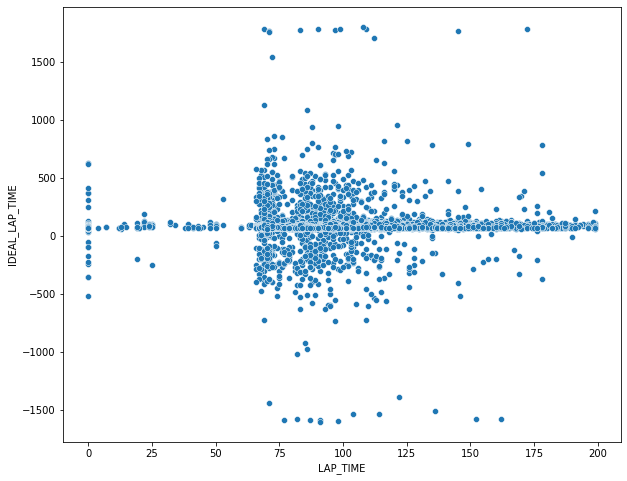

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=train.LAP_TIME, y=train.IDEAL_LAP_TIME)
plt.show()

* There is a dense collection of points towards the middle forming a straight line. It looks horizontal because we have some huge outliers which distorted the scale of the y-axis. Ideally, we should have seen a line with slope = 1. 
* We can also see there are some records with LAP_TIME = 0 visible towards the left of the plot.  

Let us check the records which contain the outliers and handle them.

In [ ]:
time_columns = ['S1_LARGE', 'S2_LARGE', 'S3_LARGE', 'PIT_TIME', 'PITSTOP_TAKEN', 'LAP_TIME', 'CROSSING_FINISH_LINE_IN_PIT']

In [ ]:
train.loc[train.IDEAL_LAP_TIME > 500][time_columns].head()

,S1_LARGE,S2_LARGE,S3_LARGE,PIT_TIME,PITSTOP_TAKEN,LAP_TIME,CROSSING_FINISH_LINE_IN_PIT
1028,48.0,48.5,444.6,0.0,False,178,B
1046,24.8,24.8,664.3,0.0,False,96,B
1787,33.2,36.3,455.8,0.0,False,74,B
1791,26.9,29.4,483.5,0.0,False,93,B
1930,32.7,31.0,568.2,0.0,False,116,B


There are some huge sector-3 timings here but no pitstops were recorded. Race-cars would need to slow down to a crawl to take so much time to cover a sector without pitstops. But we also see that the CROSSING_FINISH_LINE_IN_PIT value is 'B' in all cases. Sector timing might be big because the car did not complete that sector due to some damage or mechanical failure, but it was still recorded.  
We could remove all rows with CROSSING_FINISH_LINE_IN_PIT == 'B' since those lap timings would be invalid. However, we also have a small number of such rows in the test set so we cannot simply ignore them.

In [ ]:
train[time_columns].describe()

,S1_LARGE,S2_LARGE,S3_LARGE,PIT_TIME,LAP_TIME
count,10272.000000,10268.000000,10242.000000,10276.000000,10276.000000
mean,51.723851,31.368806,44.602802,37.210880,92.670884
std,93.588470,8.745657,86.454768,127.247166,26.206425
min,21.400000,17.500000,18.800000,0.000000,0.000000
25%,24.900000,24.000000,26.700000,0.000000,75.000000
50%,27.900000,31.600000,29.900000,0.000000,89.000000
75%,33.400000,36.000000,35.000000,0.000000,103.000000
max,2377.900000,128.800000,1741.100000,2350.200000,199.000000


* S2_LARGE looks mostly consistent with a very small standard deviation. Even the max value is only 128 seconds which can be explained by a short pit time.  
* S1_LARGE has a very high max value of 2377 seconds but we can see the max value for pit time which is 2350 seconds and is probably in the same record. We will confirm it later.
* S3_LARGE was the most inconsistent column as we saw ealier, and the 1000+ seconds records actually have no PIT_TIME associated with them.
* The minimum LAP_TIME is 0, as we also saw in the IDEAL_LAP_TIME graph, which is not possible and we need to correct or remove those records.

Using the minimum values of sector timings, the best possible lap across all locations is 21.4 + 17.5 + 18.8 = 57.7

In [ ]:
len(train.loc[train.LAP_TIME == 0]), len(train.loc[train.LAP_TIME < 57.7])

(140, 205)

In [ ]:
train.loc[train.LAP_TIME < 57.7].sample(5)

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1_IMPROVEMENT,S2_IMPROVEMENT,S3_IMPROVEMENT,KPH,ELAPSED,HOUR,S1_LARGE,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT,PITSTOP_TAKEN,IDEAL_LAP_TIME
10192,71,1,14,24,0,NaN,0,0,0,96.8,18:39.6,18:39.6,28.5,28.8,30.3,NN,0.0,NaN,ROK,NaN,Location 8,Free Practice 1,False,87.6
9614,29,1,8,0,0,NaN,0,0,0,123.2,15:06.2,45:06.2,23.0,21.8,24.0,AS,0.0,NaN,MAHINDRAd,NaN,Location 8,Free Practice 2,False,68.8
10220,88,1,2,13,0,B,0,0,0,110.1,02:39.9,02:39.9,24.0,22.9,30.1,TB,0.0,NaN,NIOO,NaN,Location 8,Free Practice 1,False,77.0
1622,99,1,18,50,0,NaN,0,0,0,41.2,40:56.2,40:56.2,223.7,36.7,34.3,PWEHRL,192.9,NaN,TAG,NaN,Location 3,Free Practice 3,True,101.8
9103,29,1,24,0,0,NaN,0,0,0,105.0,43:07.5,43:07.5,25.1,25.3,30.3,AS,0.0,NaN,MAHINDRAd,250.0,Location 8,Free Practice 1,False,80.7


These lap timings also look incorrect, we will remove them too.

In [ ]:
train.drop(train[train.LAP_TIME < 57.7].index, inplace=True)

In [ ]:
train[time_columns].describe()

,S1_LARGE,S2_LARGE,S3_LARGE,PIT_TIME,LAP_TIME
count,10067.000000,10063.000000,10037.000000,10071.000000,10071.000000
mean,51.939625,31.454069,44.667062,37.292672,94.361434
std,94.090456,8.753330,86.756760,127.753715,23.498037
min,21.400000,17.500000,18.800000,0.000000,60.000000
25%,24.900000,24.300000,26.900000,0.000000,76.000000
50%,27.900000,31.800000,30.000000,0.000000,90.000000
75%,33.400000,36.100000,35.100000,0.000000,104.000000
max,2377.900000,128.800000,1741.100000,2350.200000,199.000000


Now the minimum lap time is a reasonable 60 seconds, which would still be very fast, but possible.  
With LAP_TIME fixed, we will now fix the sector timings.

First, dealing with missing values:  
Test set has 2 rows with missing S3 values. S1 and S2 are never missing. We will drop rows with S1 or S2 missing, and handle missing S3 differently.

In [ ]:
train.drop(train[train.S1_LARGE.isna()].index, inplace=True)
train.drop(train[train.S2_LARGE.isna()].index, inplace=True)

In [ ]:
train.shape[0]

10063

Let's confirm if missing S3_LARGE is also connected to CROSSING_FINISH_LINE_IN_PIT

In [ ]:
len(train.loc[train.S3_LARGE.isna() & train.CROSSING_FINISH_LINE_IN_PIT.isna()])

0

S3_LARGE is missing only if CROSSING_FINISH_LINE_IN_PIT is not!

In [ ]:
train.loc[train.S3_LARGE.isna()]['CROSSING_FINISH_LINE_IN_PIT'].unique()

array(['B'], dtype=object)

CROSSING_FINISH_LINE_IN_PIT == 'B' definitely signifies missing S3 values. Thus, we can extrapolate that the unrealistically large S3 values with CROSSING_FINISH_LINE_IN_PIT == 'B' are also equivalent to missing values which were erroneously recorded.

In [ ]:
train.loc[~train.CROSSING_FINISH_LINE_IN_PIT.isna()][time_columns].describe()

,S1_LARGE,S2_LARGE,S3_LARGE,PIT_TIME,LAP_TIME
count,1196.000000,1196.000000,1168.000000,1196.000000,1196.000000
mean,31.501923,33.121739,150.398716,4.230769,93.237458
std,27.576431,12.462808,227.078760,34.370985,22.755689
min,22.100000,17.900000,27.300000,0.000000,63.000000
25%,24.900000,24.300000,35.400000,0.000000,74.000000
50%,27.200000,32.400000,51.250000,0.000000,89.000000
75%,30.700000,35.700000,200.575000,0.000000,102.000000
max,468.500000,128.800000,1741.100000,450.500000,199.000000


Mean S3_LARGE is around 150 for the subset while it was around 44 for the whole dataset. The upper quartile is 200 instead of 35.

In [ ]:
len(train.loc[~train.CROSSING_FINISH_LINE_IN_PIT.isna() & train.PITSTOP_TAKEN])

29

Legitimate PIT_TIME recorded only for 29/1196 times when CROSSING_FINISH_LINE_IN_PIT is not missing.

Setting all high value S3_LARGE to NaN wherever CROSSING_FINISH_LINE_IN_PIT is 'B' and pitstop was not recorded.

In [ ]:
train['S3_LARGE'] = train['S3_LARGE'].mask(~train.CROSSING_FINISH_LINE_IN_PIT.isna() &
                                           ~train.PITSTOP_TAKEN &
                                           (train.S3_LARGE > 50))

Dropping rows with sum of sector timings (with PIT_TIME removed) is more than maximum possible value of LAP_TIME

In [ ]:
train.drop(train[(train.S1_LARGE + train.S2_LARGE + train.S3_LARGE - train.PIT_TIME > 199)].index, inplace=True)

In [ ]:
train.shape[0]

10054

In [ ]:
train[time_columns].describe()

,S1_LARGE,S2_LARGE,S3_LARGE,PIT_TIME,LAP_TIME
count,10054.000000,10054.000000,9440.000000,10054.000000,10054.000000
mean,51.846210,31.427322,31.168326,37.226477,94.366919
std,93.996049,8.680918,8.105229,127.761336,23.513199
min,21.400000,17.500000,18.800000,0.000000,60.000000
25%,24.900000,24.300000,26.500000,0.000000,76.000000
50%,27.900000,31.800000,29.700000,0.000000,90.000000
75%,33.400000,36.000000,33.600000,0.000000,104.000000
max,2377.900000,128.800000,131.200000,2350.200000,199.000000


Now we have realistic sector timings if we consider the PIT_TIME included with them.

In [ ]:
#dropping the calculated columns we created since they do not seem to be useful
train.drop(['IDEAL_LAP_TIME'], axis=1, inplace=True)

### Feature: DRIVER_NUMBER

In [ ]:
train['DRIVER_NUMBER'].value_counts()

1    10054
Name: DRIVER_NUMBER, dtype: int64

In [ ]:
test['DRIVER_NUMBER'].value_counts()

1    420
Name: DRIVER_NUMBER, dtype: int64

DRIVER_NUMBER has only one unique value across training and test data. It can't give us any useful information. Dropping this column.

In [ ]:
train.drop(['DRIVER_NUMBER'], axis=1, inplace=True)
test.drop(['DRIVER_NUMBER'], axis=1, inplace=True)

### Feature: DRIVER_NAME

In [ ]:
train['DRIVER_NAME'].unique()

array(['SB', 'LGRA', 'ACO', 'NVR', 'MEV', 'OROWL', 'SBU', 'M¬úNT', 'AS',
       'RR', 'ALOTTE', 'N', 'RFRI', 'EMORT', 'SVANDOO', 'N¬úL', 'S¬ÇM',
       'NN', 'AL', 'PWEHRL', 'JVER', 'J', 'OTUR', 'TB'], dtype=object)

In [ ]:
set(train['DRIVER_NAME'].unique()) - set(test['DRIVER_NAME'].unique()) #extra drivers in train set -> 1 

{'N¬úL'}

In [ ]:
set(test['DRIVER_NAME'].unique()) - set(train['DRIVER_NAME'].unique()) #unseen drivers in test set -> 0

set()

We will explore the relationship between DRIVER_NAME and other identifying features next.

### Features: NUMBER and TEAM

In [ ]:
train['NUMBER'].nunique()

24

In [ ]:
train.groupby('TEAM')['NUMBER'].unique()

TEAM
AD               [11]
AR               [33]
BMWE             [27]
BMWl             [28]
DRAGONR           [6]
DRAGONo           [7]
DRAGON√É          [6]
DSo              [13]
DS¬â             [25]
EA               [37]
EF                [4]
JE               [20]
JR               [10]
MAHINDRAd    [29, 94]
ME               [17]
Ml                [5]
N                [22]
NIO               [8]
NIOO             [88]
Nt               [23]
ROK              [71]
ROKo             [48]
TAG          [36, 99]
Name: NUMBER, dtype: object

* It clearly looks like some of the team names are erroneous (e.g. DRAGONR, DRAGONo and DRAGON√É look like the same team. So do ROK and ROKo). 
* From a web search on Formula-E rules, we can see that **every season we have a fixed number of teams with two cars each**. We can see from MAHINDRAd and TAG, teams have two associated numbers.
* If we fix team names we can see team ROK will have two cars: 48 and 71, team Dragon will have two cars: 6 and 7, and so on. **The associated numbers must be car numbers.**
* 24 unique car numbers means we have 12 teams. Looking through Formula-E season history on Wikipedia, only two seasons had 12 teams competing: 2019-20 and 2020-21. We will look through the teams to fix our team names.
 

In [ ]:
train.groupby('NUMBER')['DRIVER_NAME'].unique()

NUMBER
4        [RFRI]
5     [SVANDOO]
6     [N¬úL, J]
7        [S¬ÇM]
8        [OTUR]
10         [SB]
11       [LGRA]
13        [ACO]
17        [NVR]
20        [MEV]
22      [OROWL]
23        [SBU]
25       [JVER]
27          [J]
28      [M¬úNT]
29         [AS]
33         [RR]
36     [ALOTTE]
37          [N]
48      [EMORT]
71         [NN]
88         [TB]
94         [AL]
99     [PWEHRL]
Name: DRIVER_NAME, dtype: object

From Formula-E history, we can see that driver-switching is common, but the car numbers remain the same throughout the season. In our dataset, we see only one car has multiple drivers associated with it. Comparing the 2019-2020 and the 2020-2021 seasons, it looks like we have the data from 2020-2021 season where the only car with multiple drivers was: Car number 6, Team Dragon/Penske Autosport (DRAGONR, DRAGONo, DRAGON√É), with drivers Nico Muller (N¬úL) and Joel Eriksson (J).

**All this background information will not leak data to help with our data modeling, but it will help us clean the data and explore it better. Additionally, it is good to know we are probably using actual data from the latest completed season!**

In [ ]:
train.TEAM.unique() #looks like there are spaces in some of the correct-looking names too

array(['JR', 'AD', 'DSo', 'ME', 'JE', 'N ', 'Nt', 'BMWl', 'MAHINDRAd',
       'AR', 'TAG ', 'EA', 'EF', 'ROKo', 'Ml', 'DRAGON√É', 'DRAGONo',
       'ROK ', 'DS¬â', 'BMWE', 'NIO ', 'NIOO', 'DRAGONR'], dtype=object)

In [ ]:
#mapping for team names: 'TEAM'
team_mapping = {
    'AD': 'AUDI', 'AR': 'AUDI',  #Audi Sport ABT Schaeffler Formula E Team
    'BMWE': 'BMW', 'BMWl': 'BMW',  #BMW i Andretti Motorsport
    'DRAGONR': 'DRAGON', 'DRAGONo': 'DRAGON', 'DRAGON√É': 'DRAGON',  #Dragon/Penske Autosport
    'DSo': 'DS', 'DS¬â': 'DS',  #DS Techeetah
    'EA': 'ENVISION', 'EF': 'ENVISION',  #Envision Virgin Racing
    'JE': 'JAGUAR', 'JR': 'JAGUAR',  #Jaguar Racing
    'MAHINDRAd': 'MAHINDRA',  #Mahindra Racing
    'ME': 'MERCEDES', 'Ml': 'MERCEDES',  #Mercedes-EQ Formula E Team
    'NIO ': 'NIO', 'NIOO': 'NIO',  #NIO 333 FE Team
    'N ': 'NISSAN', 'Nt': 'NISSAN',  #Nissan e.dams
    'ROK ': 'ROKIT', 'ROKo': 'ROKIT',  #ROKiT Venturi Racing
    'TAG ': 'TAG'  #TAG Heuer Porsche Formula E Team
}

In [ ]:
train.DRIVER_NAME.unique()

array(['SB', 'LGRA', 'ACO', 'NVR', 'MEV', 'OROWL', 'SBU', 'M¬úNT', 'AS',
       'RR', 'ALOTTE', 'N', 'RFRI', 'EMORT', 'SVANDOO', 'N¬úL', 'S¬ÇM',
       'NN', 'AL', 'PWEHRL', 'JVER', 'J', 'OTUR', 'TB'], dtype=object)

In [ ]:
#mapping for DRIVER_NAME - not required for modeling, but applying it
#to remove problematic characters in names, and better understanding.
driver_mapping = {
    'RFRI': 'FRIJNS', 'SVANDOO': 'VANDOORNE', 'N¬úL': 'MULLER', 'J': 'ERIKSSON',
    'S¬ÇM': 'CAMARA', 'OTUR': 'TURVEY', 'SB': 'BIRD', 'LGRA': 'GRASSI', 
    'ACO': 'COSTA', 'NVR': 'VRIES', 'MEV': 'EVANS', 'OROWL': 'ROWLAND', 
    'SBU': 'BUEMI', 'JVER': 'VERGNE', 'M¬úNT': 'GUNTHER', 'AS': 'SIMS', 
    'RR': 'RAST', 'ALOTTE': 'LOTTERER', 'N': 'CASSIDY', 'EMORT': 'MORTARA', 
    'NN': 'NATO', 'TB': 'BLOMQVIST', 'AL': 'LYNN', 'PWEHRL': 'WEHRLEIN'
}

We will apply these mappings and have another look at the dataset before moving on to other features.

In [ ]:
train['DRIVER_NAME'] = train['DRIVER_NAME'].map(driver_mapping).fillna(train['DRIVER_NAME'])
test['DRIVER_NAME'] = test['DRIVER_NAME'].map(driver_mapping).fillna(test['DRIVER_NAME'])

train['TEAM'] = train['TEAM'].map(team_mapping).fillna(train['TEAM'])
test['TEAM'] = test['TEAM'].map(team_mapping).fillna(test['TEAM'])

train = train.rename(columns={'NUMBER': 'CAR_NUMBER'})
test = test.rename(columns={'NUMBER': 'CAR_NUMBER'})

In [ ]:
train[['CAR_NUMBER', 'DRIVER_NAME', 'TEAM']] = train[['CAR_NUMBER', 'DRIVER_NAME', 'TEAM']].apply(lambda x: x.astype('category').cat.codes)
test[['CAR_NUMBER', 'DRIVER_NAME', 'TEAM']] = test[['CAR_NUMBER', 'DRIVER_NAME', 'TEAM']].apply(lambda x: x.astype('category').cat.codes)

In [ ]:
train[['CAR_NUMBER', 'DRIVER_NAME', 'TEAM']].sample(10)

,CAR_NUMBER,DRIVER_NAME,TEAM
7497,22,12,6
6867,4,19,8
3671,9,7,5
7836,19,13,10
1918,16,16,0
6617,6,9,0
5593,21,1,8
7454,4,19,8
8526,10,17,9
8069,8,22,7


In [ ]:
train.duplicated().sum(), test.duplicated().sum() #checking if our mappings created any duplicates

(0, 0)

All good!

### Features: EVENT, LOCATION

In [ ]:
train['EVENT'].value_counts()

Free Practice 1       4280
Free Practice 2       2904
Free Practice 3       2366
Qualifying Group 4     134
Qualifying Group 3     129
Qualifying Group 2     121
Qualifying Group 1     120
Name: EVENT, dtype: int64

3 practice sessions: 2 x 45 mins + 1 x 30 mins  
4 qualifying groups: 24 drivers divided into 4 groups of 6 based on their championship standings. Top-6 move on to Super Pole shootout. However our dataset is limited up to the 4 Qualifying Groups.

In [ ]:
test['EVENT'].value_counts()

Qualifying Group 2    113
Qualifying Group 3    110
Qualifying Group 4     99
Qualifying Group 1     98
Name: EVENT, dtype: int64

Training set has a large proportion of 'Free Practice' but test set is purely for 'Qualifying Groups'.  
After a quick look through the results from random races across recent seasons, the best lap times in Free Practice and Qualifiying Groups tend to be the same. We can corroborate that using a few samples in our data.

In [ ]:
train.loc[(train.LOCATION == 'Location 1') & 
          (train.DRIVER_NAME == 'BIRD') & 
          (train.LAP_NUMBER == 1)][['EVENT', 'LAP_TIME']]

,EVENT,LAP_TIME


As we can see, either can be better depending on how the lap unfolded. We can check other samples by changing LOCATION, DRIVER_NAME and LAP_number.

In [ ]:
train['LOCATION'].value_counts()

Location 8    1709
Location 1    1546
Location 3    1421
Location 6    1339
Location 5    1306
Location 2    1065
Location 7     901
Location 4     767
Name: LOCATION, dtype: int64

In [ ]:
test['LOCATION'].value_counts()

Location 6    155
Location 7    153
Location 8    112
Name: LOCATION, dtype: int64

We are predicting only for Locations 6,7 and 8. We also have a significant amount of data for these locations in the training set.

In [ ]:
train.groupby('LOCATION')['EVENT'].value_counts()

LOCATION    EVENT             
Location 1  Free Practice 1       599
            Free Practice 3       497
            Free Practice 2       329
            Qualifying Group 4     35
            Qualifying Group 2     30
            Qualifying Group 3     29
            Qualifying Group 1     27
Location 2  Free Practice 1       435
            Free Practice 3       429
            Free Practice 2       100
            Qualifying Group 3     28
            Qualifying Group 4     26
            Qualifying Group 1     24
            Qualifying Group 2     23
Location 3  Free Practice 1       492
            Free Practice 3       450
            Free Practice 2       346
            Qualifying Group 3     36
            Qualifying Group 1     33
            Qualifying Group 4     33
            Qualifying Group 2     31
Location 4  Free Practice 1       397
            Free Practice 2       316
            Qualifying Group 4     17
            Qualifying Group 2     13
            Qualify

* Some locations have 3 practice sessions: Out of 8 locations, 7 had double events, resulting in a total of 15 races. Some locations have only 1 practice (Practice 3) on day 2. Other locations have 2 practices on both days which are again named Practice 1 and 2 instead of Practice 3 and 4.
* We have only free practice data for locations 6, 7 and 8 in the training set. As we saw earlier, we can expect free practice and qualifying groups lap times to be about the same depending on the LOCATION.

In [ ]:
test.groupby('LOCATION')['EVENT'].value_counts()

LOCATION    EVENT             
Location 6  Qualifying Group 2    47
            Qualifying Group 3    37
            Qualifying Group 4    36
            Qualifying Group 1    35
Location 7  Qualifying Group 3    45
            Qualifying Group 1    36
            Qualifying Group 2    36
            Qualifying Group 4    36
Location 8  Qualifying Group 2    30
            Qualifying Group 3    28
            Qualifying Group 1    27
            Qualifying Group 4    27
Name: EVENT, dtype: int64

Modifications to be made:
* Mapping the values to better names without spaces  
* Adding a new categorical column to distinguish between practice and qualifying. Since every driver/team has similar goals for different parts of the race day, there should not be much difference among the practice sessions or among the qualifying groups.

In [ ]:
event_mapping = {
    'Free Practice 1': 'P1', 'Free Practice 2': 'P2', 'Free Practice 3': 'P3',
    'Qualifying Group 1': 'Q1', 'Qualifying Group 2': 'Q2',
    'Qualifying Group 3': 'Q3', 'Qualifying Group 4': 'Q4'
}
#modifying EVENT
train['EVENT'] = train['EVENT'].map(event_mapping).fillna(train['EVENT'])
test['EVENT'] = test['EVENT'].map(event_mapping).fillna(test['EVENT'])

In [ ]:
#adding EVENT_TYPE: P->Free Practice 1/2/3, Q->Qualifying Group 1/2/3/4
train['EVENT_TYPE'] = train['EVENT'].apply(lambda row: 'P' if row in ('P1', 'P2', 'P3') else 'Q')
test['EVENT_TYPE'] = test['EVENT'].apply(lambda row: 'P' if row in ('P1', 'P2', 'P3') else 'Q')

In [ ]:
location_mapping = dict(zip(['Location ' + str(i) for i in range(1, 9)], #'Location 1'
                            ['L' + str(i) for i in range(1, 9)]))        #'L1'

#modifying LOCATION
train['LOCATION'] = train['LOCATION'].map(location_mapping).fillna(train['LOCATION'])
test['LOCATION'] = test['LOCATION'].map(location_mapping).fillna(test['LOCATION'])

In [ ]:
train[['LOCATION', 'EVENT', 'EVENT_TYPE']] = train[['LOCATION', 'EVENT', 'EVENT_TYPE']].apply(lambda x: x.astype('category').cat.codes)
test[['LOCATION', 'EVENT', 'EVENT_TYPE']] = test[['LOCATION', 'EVENT', 'EVENT_TYPE']].apply(lambda x: x.astype('category').cat.codes)

In [ ]:
train[['LOCATION', 'EVENT', 'EVENT_TYPE']].head()

,LOCATION,EVENT,EVENT_TYPE
0,1,1,0
1,1,1,0
2,1,1,0
3,1,1,0
4,1,1,0


### Features: LAP_IMPROVEMENT, S*_IMPROVEMENT, LAP_NUMBER

The data description has no proper explanation for the *_IMPROVEMENT features. So we will analyze their values and try to understand their meaning.

In [ ]:
train[['LAP_IMPROVEMENT', 'S1_IMPROVEMENT', 'S2_IMPROVEMENT', 'S3_IMPROVEMENT']].describe()

,LAP_IMPROVEMENT,S1_IMPROVEMENT,S2_IMPROVEMENT,S3_IMPROVEMENT
count,10054.000000,10054.000000,10054.000000,10054.000000
mean,0.153471,0.152775,0.154466,0.155162
std,0.556577,0.555785,0.558799,0.561005
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,4.000000,4.000000,4.000000,4.000000


More than 75% of the values are 0 for all four columns.

In [ ]:
train['LAP_IMPROVEMENT'].unique(), train['S1_IMPROVEMENT'].unique(), train['S2_IMPROVEMENT'].unique(), train['S3_IMPROVEMENT'].unique()

(array([0, 2, 3, 4]),
 array([0, 2, 3, 4]),
 array([0, 2, 3, 4]),
 array([0, 2, 3, 4]))

In [ ]:
test['LAP_IMPROVEMENT'].unique(), test['S1_IMPROVEMENT'].unique(), test['S2_IMPROVEMENT'].unique(), test['S3_IMPROVEMENT'].unique()

(array([0, 2, 4, 3]),
 array([0, 2, 4, 3]),
 array([0, 2, 4, 3]),
 array([0, 2, 4, 3]))

We have the four same values for each feature in both datasets. We can assume these must be categorical values.  
A web search about motorsport race analysis shows that lap/sector timings are color-coded for special meanings. Some of the possible situations are:  
1. Best lap/sector of that session
2. A driver's personal best lap/sector for that session
3. Most recent timing of the driver (not satisfying 1 and 2 -> slower than their own best)
4. First timing after exiting pitstop (not satisfying 1 and 2)  
5. Driver entering pitstop in that lap/sector
(Pitstops are not allowed in Formula-E races but it is possible in Free Practice and Qualifiying)  
6. Driver crashed out and could not move on to next round.

Our four categories might be based on some of these special situations.

In [ ]:
#checking the pitstop situation
train.loc[train.PITSTOP_TAKEN][['LAP_NUMBER', 'LAP_TIME', 'LAP_IMPROVEMENT', 
                                'S1_LARGE', 'S1_IMPROVEMENT', 
                                'S2_LARGE', 'S2_IMPROVEMENT', 
                                'S3_LARGE', 'S3_IMPROVEMENT', 'PIT_TIME',
                                'CROSSING_FINISH_LINE_IN_PIT']].sample(n=5)

,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,S1_LARGE,S1_IMPROVEMENT,S2_LARGE,S2_IMPROVEMENT,S3_LARGE,S3_IMPROVEMENT,PIT_TIME,CROSSING_FINISH_LINE_IN_PIT
6171,1,74,0,60.3,0,37.4,0,29.3,0,25.1,NaN
8776,1,75,0,98.0,0,25.2,0,26.9,0,62.1,NaN
4532,1,104,0,62.0,0,47.3,0,30.0,0,16.6,NaN
1522,11,88,0,435.3,0,36.8,0,31.4,0,402.9,NaN
9833,16,69,0,133.4,0,24.3,0,25.1,0,114.3,NaN


In [ ]:
train.loc[~train.PITSTOP_TAKEN][['LAP_NUMBER', 'LAP_TIME', 'LAP_IMPROVEMENT', 
                                 'S1_LARGE', 'S1_IMPROVEMENT', 
                                 'S2_LARGE', 'S2_IMPROVEMENT', 
                                 'S3_LARGE', 'S3_IMPROVEMENT', 'PIT_TIME',
                                 'CROSSING_FINISH_LINE_IN_PIT']].sample(n=5)

,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,S1_LARGE,S1_IMPROVEMENT,S2_LARGE,S2_IMPROVEMENT,S3_LARGE,S3_IMPROVEMENT,PIT_TIME,CROSSING_FINISH_LINE_IN_PIT
1947,15,90,0,34.8,0,34.5,0,37.4,0,0.0,NaN
6158,11,88,0,30.6,0,32.1,0,28.2,0,0.0,NaN
7136,5,89,0,24.5,0,20.2,0,33.7,0,0.0,NaN
1419,17,101,0,33.9,0,35.9,0,34.0,0,0.0,B
1705,14,94,0,34.4,0,46.5,0,34.9,0,0.0,NaN


In [ ]:
train.loc[train.PITSTOP_TAKEN &
          train.LAP_IMPROVEMENT != 0][['LAP_NUMBER', 'LAP_TIME', 'LAP_IMPROVEMENT', 
                                       'S1_LARGE', 'S1_IMPROVEMENT', 
                                       'S2_LARGE', 'S2_IMPROVEMENT', 
                                       'S3_LARGE', 'S3_IMPROVEMENT', 'PIT_TIME',
                                       'CROSSING_FINISH_LINE_IN_PIT']].head()

,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,S1_LARGE,S1_IMPROVEMENT,S2_LARGE,S2_IMPROVEMENT,S3_LARGE,S3_IMPROVEMENT,PIT_TIME,CROSSING_FINISH_LINE_IN_PIT


LAP_IMPROVEMENT can be 0 irrespective of whether PIT_TIME was NaN or not. But LAP_IMPROVEMENT was never 2,3 or 4 when PIT_TIME was recorded!  
Maybe because best timings will not occur in laps with pitstops.

In [ ]:
train.loc[~train.CROSSING_FINISH_LINE_IN_PIT.isna() &
          train.LAP_IMPROVEMENT != 0][['LAP_TIME', 'LAP_IMPROVEMENT', 
                                       'S1_LARGE', 'S1_IMPROVEMENT', 
                                       'S2_LARGE', 'S2_IMPROVEMENT', 
                                       'S3_LARGE', 'S3_IMPROVEMENT', 'PIT_TIME',
                                       'CROSSING_FINISH_LINE_IN_PIT']].head()

,LAP_TIME,LAP_IMPROVEMENT,S1_LARGE,S1_IMPROVEMENT,S2_LARGE,S2_IMPROVEMENT,S3_LARGE,S3_IMPROVEMENT,PIT_TIME,CROSSING_FINISH_LINE_IN_PIT


Again, LAP_IMPROVEMENT is never non-zero when CROSSING_FINISH_LINE_IN_PIT is recorded. Looks like our categories 2, 3 and 4 only occur when pitstops are not involved. And 0 may be a dummy category when none of the special situations occur.  
Let us explore the rows with non-zero LAP_IMPROVEMENT for a particular LOCATION and EVENT.

In [ ]:
train.loc[(train.LOCATION == 'L1') &
          (train.EVENT == 'Q2')][['DRIVER_NAME',
                                  'LAP_NUMBER', 'LAP_TIME', 
                                  'LAP_IMPROVEMENT', 
                                  'S1_LARGE', 'S1_IMPROVEMENT', 
                                  'S2_LARGE', 'S2_IMPROVEMENT', 
                                  'S3_LARGE', 'S3_IMPROVEMENT']]

,DRIVER_NAME,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,S1_LARGE,S1_IMPROVEMENT,S2_LARGE,S2_IMPROVEMENT,S3_LARGE,S3_IMPROVEMENT


* Consider the driver 'LOTTERER': He has three laps for Qualifying Group 2 at Location 2. His best lap, best sector-1 timing, best sector-2 timing and best sector-3 timing have '2' associated with them in the improvement columns. Coincidentally, they are all in the same row, but logic dictates the best sector timings will translate into best lap timing. Also, it is for his third lap, probably because he hass adjusted better with each lap. Same for the drivers 'ERIKSSON', 'SIMS', 'BIRD'  and 'GUNTHER'.  
* **IMPROVEMENT columns with the value 2 are definitely the personal best timings (Situation 2 in our list of assumptions).**  

* Looking at rows with *_IMPROVEMENT values equal to 4: the best sector timings for the session always have a value of 4.  

* This is enough evidence to say that the *_IMPROVEMENT columns are definitely categorical (most probably ordinal) and we need to treat them so, instead of treating them as integers values. A lap having 2s and 4s in these columns would mean that lap would definitely be a fast one. We will leave it to the model to learn about the value 3 on its own.

In [ ]:
improvement_columns = ['LAP_IMPROVEMENT', 'S1_IMPROVEMENT', 'S2_IMPROVEMENT', 'S3_IMPROVEMENT']

train[improvement_columns] = train[improvement_columns].apply(lambda x: x.astype('category').cat.codes)
test[improvement_columns] = test[improvement_columns].apply(lambda x: x.astype('category').cat.codes)

Another observation after viewing values for different events: drivers tend to put out the personal bests and session bests in later laps as they get accustomed to the track and the conditions. **This means keeping the LAP_NUMBER in our features is important since more often than not higher LAP_NUMBER would imply better times.**

### Features: CROSSING_FINISH_LINE_IN_PIT, GROUP, POWER

We must understand the columns which have a lot of missing values.  
We have already handled PIT_TIME by filling it with 0s and recording a True/False column for whether a pitstop was taken or not.  
There are some missing values for S1_LARGE, S2_LARGE and S3_LARGE too. We need to see whether those missing values are related to any of these columns.  

Let us look at the GROUP column first.

In [ ]:
train.loc[train.GROUP.isna()].sample(5)

,CAR_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1_IMPROVEMENT,S2_IMPROVEMENT,S3_IMPROVEMENT,KPH,ELAPSED,HOUR,S1_LARGE,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT,PITSTOP_TAKEN,EVENT_TYPE
5871,18,4,93,0,NaN,0,0,0,128.2,07:16.9,22:16.9,32.1,34.0,28.7,4,0.0,NaN,4,NaN,2,1,False,0
9230,1,8,68,0,NaN,0,0,0,120.0,10:29.2,10:29.2,24.4,21.9,24.3,20,0.0,NaN,7,NaN,7,0,False,0
2300,8,18,123,1,NaN,1,1,1,120.7,45:18.0,00:18.0,23.2,27.0,19.0,22,0.0,NaN,7,250.0,5,2,False,0
9500,8,20,68,1,NaN,1,2,1,127.0,27:13.7,57:13.7,22.5,20.9,23.4,22,0.0,NaN,7,250.0,7,1,False,0
3406,17,12,73,0,NaN,0,0,0,82.9,19:58.4,19:58.4,29.6,35.3,32.9,11,0.0,NaN,11,235.0,6,1,False,0


All the missing values in GROUP have EVENT_TYPE 'P' (Free Practice) associated with them. Looks like it may be the group number of the car in Qualifying Groups. 

In [ ]:
train.loc[~train.GROUP.isna() & (train.EVENT_TYPE == 'P')] #empty

,CAR_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1_IMPROVEMENT,S2_IMPROVEMENT,S3_IMPROVEMENT,KPH,ELAPSED,HOUR,S1_LARGE,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT,PITSTOP_TAKEN,EVENT_TYPE


In [ ]:
train.loc[~train.GROUP.isna()][['GROUP', 'EVENT']].sample(5)

,GROUP,EVENT
107,1.0,3
584,3.0,5
1630,2.0,4
6578,3.0,5
2177,2.0,4


Our assumption is correct. Since we already have this information in EVENT and EVENT_TYPE columns, we can safely drop GROUP column.

In [ ]:
train.drop(['GROUP'], axis=1, inplace=True)
test.drop(['GROUP'], axis=1, inplace=True)

POWER is a very important factor in Formula-E since cars are required to drive around for 45 mins + 1 lap on a single charge. Unlike other motorsports, they cannot pitstop for recharging. However, in Free Practice and Qualifying, this factor is not important because:  
* Free Practice has no restrictions on pitstops.
* Qualifying groups have drivers trying to complete a single fastest lap and do not need to last for a particular duration.

In [ ]:
train.loc[~train.POWER.isna()].sample(5)

,CAR_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1_IMPROVEMENT,S2_IMPROVEMENT,S3_IMPROVEMENT,KPH,ELAPSED,HOUR,S1_LARGE,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,TEAM,POWER,LOCATION,EVENT,PITSTOP_TAKEN,EVENT_TYPE
599,9,2,72,1,NaN,1,1,1,121.6,04:00.4,04:00.4,24.1,19.2,30.5,7,0.0,5,250.0,0,3,False,1
9959,11,17,67,0,NaN,0,0,0,28.1,28:50.0,28:50.0,250.0,26.5,25.4,2,227.5,9,250.0,7,0,True,0
7904,20,3,102,0,NaN,0,0,0,118.6,05:24.9,20:24.9,23.7,27.2,19.5,15,0.0,10,250.0,5,1,False,0
9071,14,19,91,0,B,0,0,0,23.8,35:07.9,35:07.9,24.7,23.6,NaN,10,0.0,1,235.0,7,0,False,0
7234,16,24,86,1,NaN,1,1,1,128.7,43:20.3,58:20.3,22.3,18.3,29.2,16,0.0,0,250.0,0,0,False,0


In [ ]:
train.loc[~train.POWER.isna() & (train.EVENT_TYPE == 'P')].head()

,CAR_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1_IMPROVEMENT,S2_IMPROVEMENT,S3_IMPROVEMENT,KPH,ELAPSED,HOUR,S1_LARGE,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,TEAM,POWER,LOCATION,EVENT,PITSTOP_TAKEN,EVENT_TYPE


Different POWER values for same LOCATION AND EVENT.  

A lot of values are missing, the values available are inconsistent, and the domain knowledge also reduces the importance of this feature. Hence, we will drop this column from our data.

In [ ]:
train.drop(['POWER'], axis=1, inplace=True)
test.drop(['POWER'], axis=1, inplace=True)

We have already seen the effect of CROSSING_FINISH_LINE_IN_PIT on sector timings and mitigated those outliers.
We will fill in the missing values for CROSSING_FINISH_LINE_IN_PIT and use it as a categorical feature to denote if a lap was driven with intent for completion or not.

In [ ]:
train.fillna({'CROSSING_FINISH_LINE_IN_PIT': 'A'}, inplace=True)
test.fillna({'CROSSING_FINISH_LINE_IN_PIT': 'A'}, inplace=True)

In [ ]:
train['CROSSING_FINISH_LINE_IN_PIT'] = train['CROSSING_FINISH_LINE_IN_PIT'].astype('category').cat.codes
test['CROSSING_FINISH_LINE_IN_PIT'] = test['CROSSING_FINISH_LINE_IN_PIT'].astype('category').cat.codes

### Features: HOUR, ELAPSED

These two features also do not have a satisfactory explanation in the data description so we need to make assumptions and then prove them.  

* ELAPSED: from the name we can assume it may be the total time spent by the car on the track  
* HOUR: the name gives no information so we will have to look at the values to make guesses

In [ ]:
train[['S1_LARGE', 'S2_LARGE', 'S3_LARGE', 'ELAPSED', 'HOUR']].head()

,S1_LARGE,S2_LARGE,S3_LARGE,ELAPSED,HOUR
0,343.3,35.4,43.3,07:02.0,22:02.0
1,25.7,33.4,41.9,08:43.0,23:43.0
2,28.1,34.1,NaN,10:42.5,25:42.5
3,65.0,38.4,56.8,02:40.2,17:40.2
4,28.0,36.7,44.7,04:29.7,19:29.7


After looking at a few samples we can observe:  
* ELAPSED and HOUR are always in the range of 5+ minutes (we will confirm it after converting them to seconds for easier selection). This could mean they are related to the total time spent on the track as a very slow lap also finishes in about 2 minutes.
* HOUR is always equal to or more than ELAPSED. We can guess that ELAPSED is the time spent on the track and HOUR is the total time since the start of the event. Free Practice does not require all drivers to start together, they can enter the track after the start, spend some time driving and leave before the end. We can confirm that by looking at values for a particular LOCATION and EVENT.  

First, converting them to seconds.

In [ ]:
train[['ELAPSED', 'HOUR']] = train[['ELAPSED', 'HOUR']].applymap(to_seconds)
test[['ELAPSED', 'HOUR']] = test[['ELAPSED', 'HOUR']].applymap(to_seconds)

In [ ]:
train['DIFF'] = train.HOUR - train.ELAPSED
train.loc[train.DIFF < 0][['ELAPSED', 'HOUR']]

,ELAPSED,HOUR
268,1811.6,1811.5
520,850.9,850.8
614,1258.7,358.7
615,1340.5,440.5
616,1408.9,508.9
...,...,...
9768,1803.6,3.6
9784,1819.8,19.8
9817,1823.7,23.7
9834,1816.2,16.2


We have 513 out of 10276 rows with ELAPSED > HOUR. Some of these look like an error in conversion or recording since there is a difference of only 0.1 seconds. The remaining rows are so few that we can attribute it to inconsistency in the dataset.  
We tried to confirm our assumption about the meanings of the feature names and it is almost 100% correct, but we haven't decided to use these features yet.

Time spent on the track (ELAPSED) would effect the condition of the car, with respect to tyres, remaining power, etc. The race timer (HOUR) might also be an indicator for the changes in condition of the track itself. **These would be important factors in the final race, but in Free Practice and Qualifying they are almost nullified. For those reasons, we will drop them from our dataset before modeling.**

In [ ]:
train.drop(['DIFF', 'ELAPSED', 'HOUR'], axis=1, inplace=True)
test.drop(['ELAPSED', 'HOUR'], axis=1, inplace=True)

### Feature: KPH

In [ ]:
train.loc[train.KPH.isna()][['KPH', 'S1_LARGE', 'S2_LARGE', 'S3_LARGE']].sample(5)

,KPH,S1_LARGE,S2_LARGE,S3_LARGE
2259,NaN,25.1,29.2,NaN
8156,NaN,27.3,29.9,NaN
8376,NaN,31.7,50.8,NaN
8411,NaN,173.2,31.2,NaN
8011,NaN,23.5,27.1,NaN


KPH is missing only when S3_LARGE is missing i.e., the lap was not completed. We will fill the missing values with the **median KPH** as a representation of average KPH.

In [ ]:
train['KPH'].fillna(train['KPH'].median(), inplace=True)
test['KPH'].fillna(test['KPH'].median(), inplace=True)

# Final preprocessed train.csv, test.csv

In [ ]:
train['PITSTOP_TAKEN'] = train.PITSTOP_TAKEN.astype('category').cat.codes
test['PITSTOP_TAKEN'] = test.PITSTOP_TAKEN.astype('category').cat.codes

In [ ]:
test.dtypes

CAR_NUMBER                        int8
LAP_NUMBER                       int64
LAP_TIME                       float64
LAP_IMPROVEMENT                   int8
CROSSING_FINISH_LINE_IN_PIT       int8
S1_IMPROVEMENT                    int8
S2_IMPROVEMENT                    int8
S3_IMPROVEMENT                    int8
KPH                            float64
S1_LARGE                       float64
S2_LARGE                       float64
S3_LARGE                       float64
DRIVER_NAME                       int8
PIT_TIME                       float64
TEAM                              int8
LOCATION                          int8
EVENT                             int8
PITSTOP_TAKEN                     int8
EVENT_TYPE                        int8
dtype: object

In [ ]:
test.drop(['LAP_TIME'], axis=1, inplace=True)

In [ ]:
train.to_csv('proc_train.csv', index=False)
test.to_csv('proc_test.csv', index=False)

# Data Exploration: train_weather.csv, test_weather.csv

The first question we need to consider is: **do we need the weather data to predict laps which have already occurred?**

The **weather conditions are an important factor** in predicting the expected lap time. For instance, humid air causes cars to create less downforce which would affect the efficiency of the car throughtout the lap and we would expect a slower lap time.

However, **we already have other data that would be recorded after the lap has finished**, such as KPH over the lap. This creates the possibility that the real-time data i.e., weather data might be rendered less useful.  

To handle this we can maintain two datasets to train different models: 
1. preprocessed version of train/test.csv
2. preprocessed version of train/test.csv aggregated with weather data  

First we need to check if the weather data will be useful at all.

In [ ]:
train_weather.sample(5)

,TIME_UTC_SECONDS,TIME_UTC_STR,AIR_TEMP,TRACK_TEMP,HUMIDITY,PRESSURE,WIND_SPEED,WIND_DIRECTION,RAIN,LOCATION,EVENT
167,1619331219,25/04/21 6:13,12.2778,11.9,92,992.923,0,332,-1,Location 3,Free Practice 3
577,1624122142,19/06/21 17:02,"1,98,333","39,4",72,"7,75,619","1,06,093",175,-1,Location 5,Qualifying Group 1
755,1614338781,26/02/21 11:26,20.9444,34.1,35,937.183,2.12187,306,-1,Location 1,Free Practice 2
804,1614268743,25/02/21 15:59,17.2778,19,45,937.454,4.24374,285,-1,Location 1,Free Practice 1
390,1627056402,23/07/21 16:06,"20,85",24,"65,39","1014,93","21,84",9,0,Location 7,Free Practice 1


In [ ]:
test_weather.sample(5)

,TIME_UTC_SECONDS,TIME_UTC_STR,AIR_TEMP,TRACK_TEMP,HUMIDITY,PRESSURE,WIND_SPEED,WIND_DIRECTION,RAIN,LOCATION,EVENTS
4,1628921063,14/08/21 6:04,"20,27","25,1","64,14","1016,5","11,28",204,0,Location 8,Free Practice 2
39,1628867157,13/08/21 15:05,"29,81","37,8","39,26","1014,06","5,63",222,0,Location 8,Free Practice 1
75,1628869318,13/08/21 15:41,"29,47","35,4","39,27","1013,92","12,02",214,0,Location 8,Free Practice 1
139,1629008049,15/08/21 6:14,"20,02","24,6","63,39","1011,22","6,65",51,0,Location 8,Free Practice 1
7,1628921243,14/08/21 6:07,"20,14",25,"64,39","1016,49","7,58",207,0,Location 8,Free Practice 2
